# **Function calling**
- https://platform.openai.com/docs/guides/function-calling?api-mode=responses
- https://cookbook.openai.com/examples/how_to_call_functions_with_chat_models

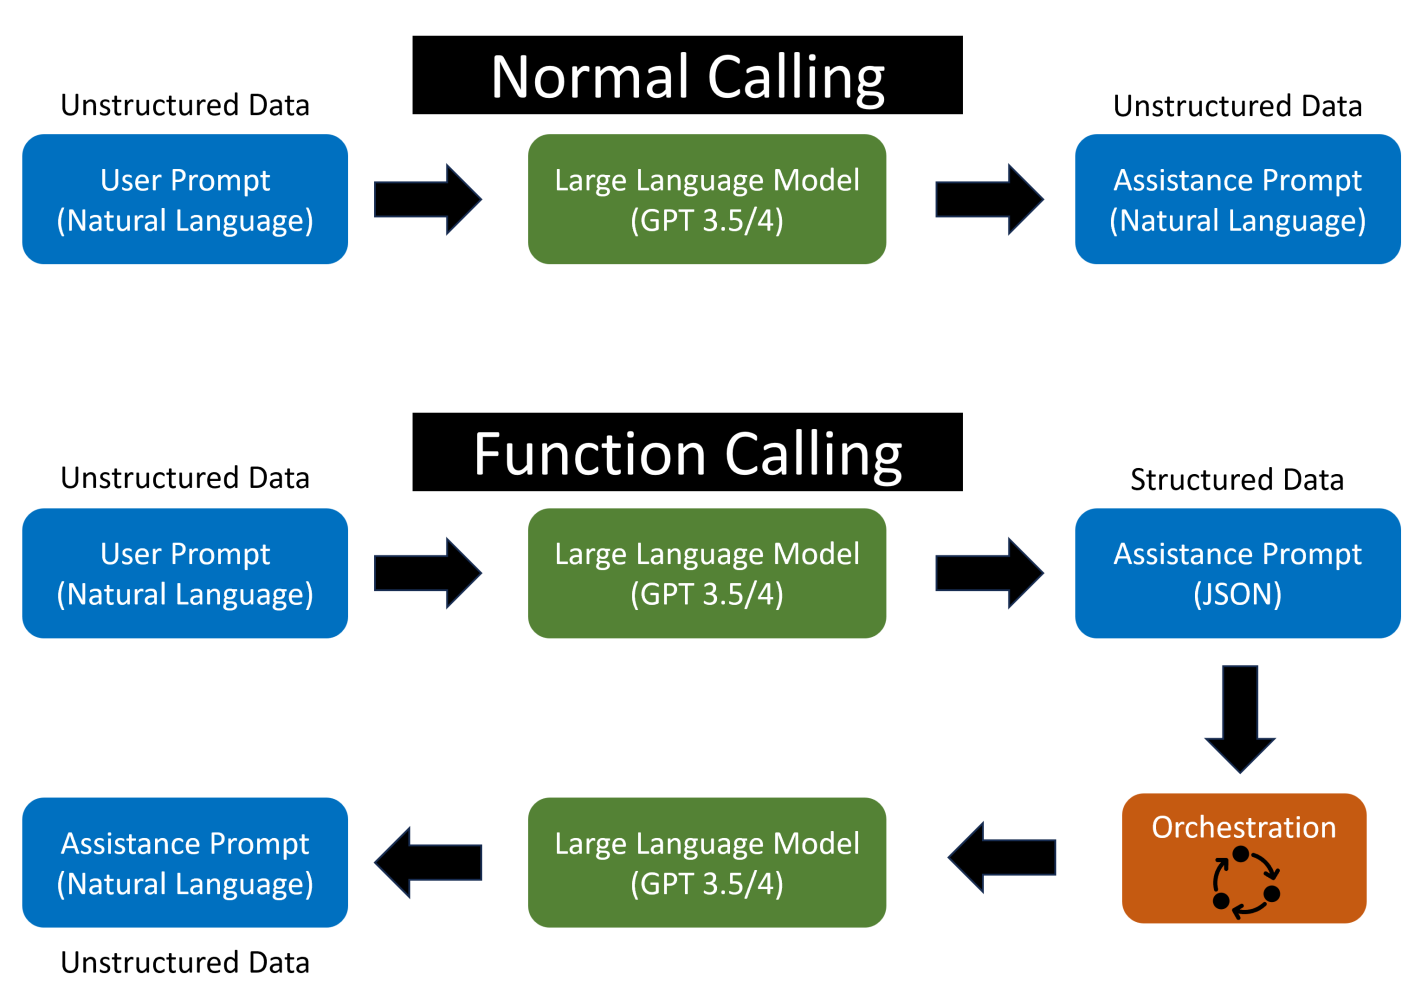
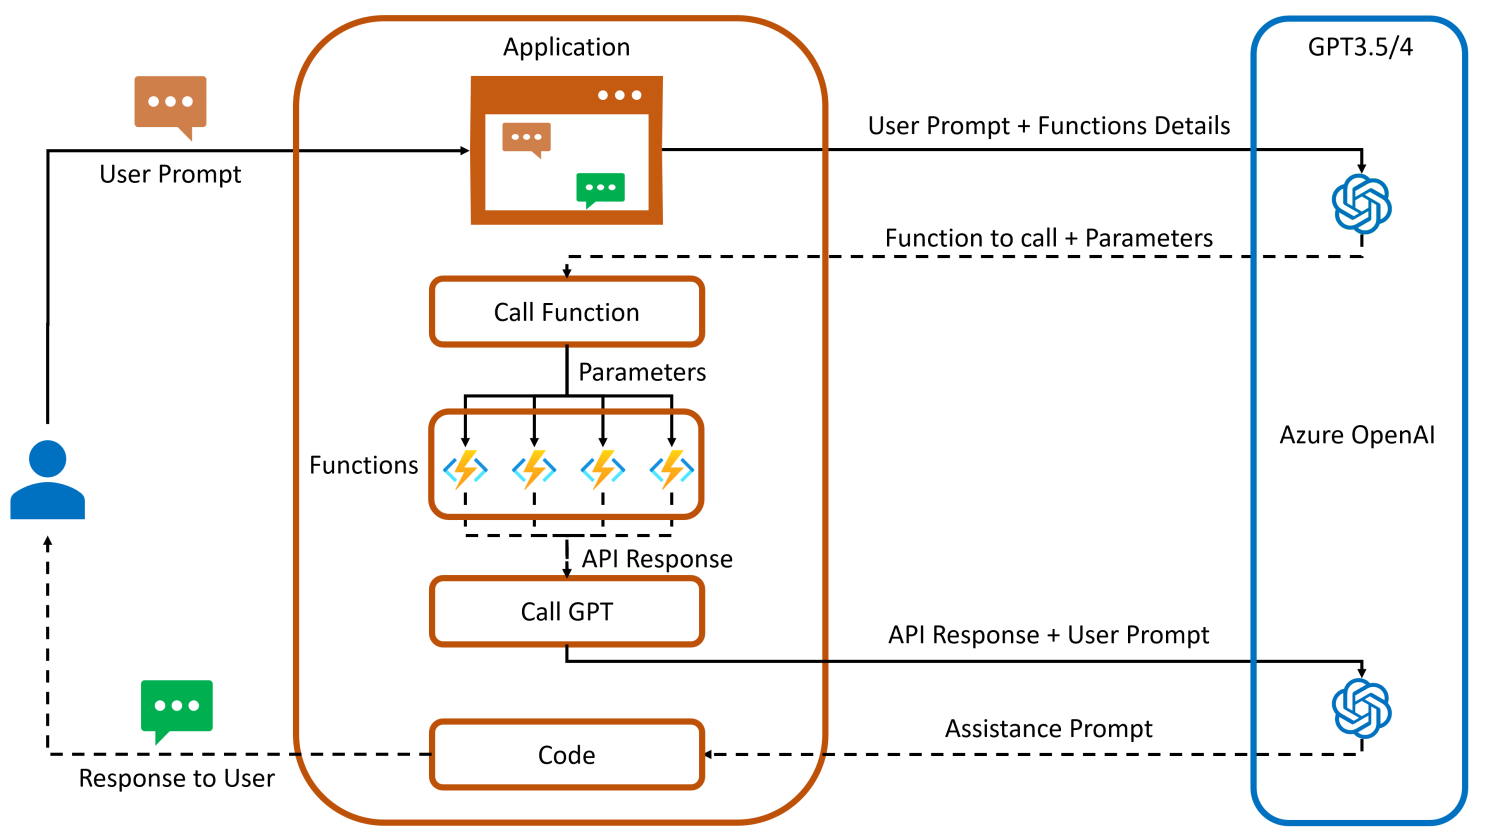

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from openai import OpenAI
from dotenv import find_dotenv, load_dotenv

In [4]:
_ : bool = load_dotenv(find_dotenv()) # read local .env file

client : OpenAI = OpenAI()

In [5]:
_

True

In [6]:
# Get the key
api_key = os.getenv("OPENAI_API_KEY")

# Check and print whether it's loaded
if api_key:
    print("🔐 OpenAI Key Loaded:", bool(api_key))  # True or False
if not api_key:
    raise EnvironmentError("❌ OPENAI_API_KEY not found in .env file!")

🔐 OpenAI Key Loaded: True


In [7]:
import json

def convert_currency(amount: float, from_currency: str, to_currency: str) -> str:
    """Convert currency using a dummy rate (in real app use an API)"""
    # Simulated static exchange rates
    rates = {
        "usd_to_pkr": 278,
        "eur_to_usd": 1.1,
        "usd_to_eur": 0.91,
        "pkr_to_usd": 0.0036
    }
    
    key = f"{from_currency.lower()}_to_{to_currency.lower()}"
    rate = rates.get(key)
    
    if rate:
        converted = round(amount * rate, 2)
        return json.dumps({
            "amount": amount,
            "from_currency": from_currency.upper(),
            "to_currency": to_currency.upper(),
            "converted_amount": converted,
            "rate_used": rate
        })
    else:
        return json.dumps({
            "error": "Conversion rate not available",
            "from_currency": from_currency,
            "to_currency": to_currency
        })


#### **Function calling with custom Currency conversion function**

In [13]:
def run_currency_conversion(main_request: str) -> str:
    messages = [{"role": "user", "content": main_request}]
    
    # Function tool definition
    tools = [
        {
            "type": "function",
            "function": {
                "name": "convert_currency",
                "description": "Convert currency from one to another using exchange rate",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "amount": {
                            "type": "number",
                            "description": "Amount of money to convert"
                        },
                        "from_currency": {
                            "type": "string",
                            "description": "Currency to convert from, e.g. USD"
                        },
                        "to_currency": {
                            "type": "string",
                            "description": "Currency to convert to, e.g. PKR"
                        }
                    },
                    "required": ["amount", "from_currency", "to_currency"]
                }
            }
        }
    ]

    # First Request to OpenAI
    response: ChatCompletion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        tools=tools,
        tool_choice="auto"  # let model decide
    )

    response_message: ChatCompletionMessage = response.choices[0].message
    display("* First Response: ", dict(response_message))

    tool_calls = response_message.tool_calls
    display("* First Response Tool Calls: ", list(tool_calls))

    # Step 2: Check if model decided to call a tool
    if tool_calls:
        available_functions = {
            "convert_currency": convert_currency,
        }

        # Extend messages with assistant’s reply
        messages.append(response_message)

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)

            function_response = function_to_call(
                amount=function_args.get("amount"),
                from_currency=function_args.get("from_currency"),
                to_currency=function_args.get("to_currency")
            )

            # Append tool response to messages
            messages.append({
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            })

        display("* Second Request Messages: ", list(messages))

        # Step 3: Second request to model including tool response
        second_response: ChatCompletion = client.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=messages
        )

        print("* Second Response: ", dict(second_response))
        return second_response.choices[0].message.content

In [14]:
result = run_currency_conversion("Convert 100 USD to PKR")
print(result)

'* First Response: '

{'content': None,
 'refusal': None,
 'role': 'assistant',
 'annotations': [],
 'audio': None,
 'function_call': None,
 'tool_calls': [ChatCompletionMessageToolCall(id='call_JwAVnakcvLjPKFsdHiqcRA12', function=Function(arguments='{"amount": 100, "from_currency": "USD", "to_currency": "PKR"}', name='convert_currency'), type='function'),
  ChatCompletionMessageToolCall(id='call_LUh3ThoupDh29vWSOZJKprxg', function=Function(arguments='{"amount": 100, "from_currency": "USD", "to_currency": "CAD"}', name='convert_currency'), type='function')]}

'* First Response Tool Calls: '

[ChatCompletionMessageToolCall(id='call_JwAVnakcvLjPKFsdHiqcRA12', function=Function(arguments='{"amount": 100, "from_currency": "USD", "to_currency": "PKR"}', name='convert_currency'), type='function'),
 ChatCompletionMessageToolCall(id='call_LUh3ThoupDh29vWSOZJKprxg', function=Function(arguments='{"amount": 100, "from_currency": "USD", "to_currency": "CAD"}', name='convert_currency'), type='function')]

'* Second Request Messages: '

[{'role': 'user', 'content': 'Convert 100 USD to PKR'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_JwAVnakcvLjPKFsdHiqcRA12', function=Function(arguments='{"amount": 100, "from_currency": "USD", "to_currency": "PKR"}', name='convert_currency'), type='function'), ChatCompletionMessageToolCall(id='call_LUh3ThoupDh29vWSOZJKprxg', function=Function(arguments='{"amount": 100, "from_currency": "USD", "to_currency": "CAD"}', name='convert_currency'), type='function')]),
 {'tool_call_id': 'call_JwAVnakcvLjPKFsdHiqcRA12',
  'role': 'tool',
  'name': 'convert_currency',
  'content': '{"amount": 100, "from_currency": "USD", "to_currency": "PKR", "converted_amount": 27800, "rate_used": 278}'},
 {'tool_call_id': 'call_LUh3ThoupDh29vWSOZJKprxg',
  'role': 'tool',
  'name': 'convert_currency',
  'content': '{"error": "Conversion rate not available", "from_currency": "USD", "to_

* Second Response:  {'id': 'chatcmpl-BvMN5qch1woAQOm3aYCpmUEe5xHTe', 'choices': [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='100 USD is approximately equal to 27,800 PKR.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], 'created': 1753010391, 'model': 'gpt-3.5-turbo-1106', 'object': 'chat.completion', 'service_tier': 'default', 'system_fingerprint': 'fp_982035f36f', 'usage': CompletionUsage(completion_tokens=13, prompt_tokens=149, total_tokens=162, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))}
100 USD is approximately equal to 27,800 PKR.


#### **Function calling with custom weather function**

In [15]:
# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location:str, unit:str="fahrenheit")->str:
    """Get the current weather in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": "celsius"})
    elif "san francisco" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "72", "unit": "fahrenheit"})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": "celsius"})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})

In [19]:
from openai.types.chat.chat_completion import ChatCompletionMessage, ChatCompletion
# from openai.types.chat.chat_completion import ChatCompletionMessageParam, ChatCompletionMessageParam

def run_conversation(main_request: str)->str:
    # Step 1: send the conversation and available functions to the model
    messages = [{"role": "user", "content": main_request}]
    tools = [
        {
            "type": "function",
            "function": {
                "name": "get_current_weather",
                "description": "Get the current weather in a given location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "The city and state, e.g. San Francisco, CA",
                        },
                        "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                    },
                    "required": ["location"],
                },
            },
        }
    ]

    # First Request
    response: ChatCompletion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        tools=tools,
        tool_choice="auto",  # auto is default, but we'll be explicit
    )
    response_message: ChatCompletionMessage = response.choices[0].message
    display("* First Response: ", dict(response_message))

    tool_calls = response_message.tool_calls
    if tool_calls is not None:
        display("* First Reponse Tool Calls: ", list(tool_calls))
    else:
        display("* First Reponse Tool Calls: ", None)


    # Step 2: check if the model wanted to call a function
    if tool_calls:
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        available_functions = {
            "get_current_weather": get_current_weather,
        }  # only one function in this example, but you can have multiple
        
        messages.append(response_message)  # extend conversation with assistant's reply
        
        # Step 4: send the info for each function call and function response to the model
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                location=function_args.get("location"),
                unit=function_args.get("unit"),
            )
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }
            )  # extend conversation with function response
        display("* Second Request Messages: ", list(messages))
        second_response: ChatCompletion = client.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=messages,
        )  # get a new response from the model where it can see the function response
        print("* Second Response: ", dict(second_response))
        return second_response.choices[0].message.content

In [20]:
run_conversation("What's the weather like in San Francisco, Tokyo, and Paris?")

'* First Response: '

{'content': None,
 'refusal': None,
 'role': 'assistant',
 'annotations': [],
 'audio': None,
 'function_call': None,
 'tool_calls': [ChatCompletionMessageToolCall(id='call_YyX65v0mmftyjp7H49Ll0XSW', function=Function(arguments='{"location": "San Francisco, CA", "unit": "celsius"}', name='get_current_weather'), type='function'),
  ChatCompletionMessageToolCall(id='call_tDpBaLESCNNpsHD7VjXjPKA6', function=Function(arguments='{"location": "Tokyo, Japan", "unit": "celsius"}', name='get_current_weather'), type='function'),
  ChatCompletionMessageToolCall(id='call_d1akFKteo9rpnREsck7hT8o2', function=Function(arguments='{"location": "Paris, France", "unit": "celsius"}', name='get_current_weather'), type='function')]}

'* First Reponse Tool Calls: '

[ChatCompletionMessageToolCall(id='call_YyX65v0mmftyjp7H49Ll0XSW', function=Function(arguments='{"location": "San Francisco, CA", "unit": "celsius"}', name='get_current_weather'), type='function'),
 ChatCompletionMessageToolCall(id='call_tDpBaLESCNNpsHD7VjXjPKA6', function=Function(arguments='{"location": "Tokyo, Japan", "unit": "celsius"}', name='get_current_weather'), type='function'),
 ChatCompletionMessageToolCall(id='call_d1akFKteo9rpnREsck7hT8o2', function=Function(arguments='{"location": "Paris, France", "unit": "celsius"}', name='get_current_weather'), type='function')]

'* Second Request Messages: '

[{'role': 'user',
  'content': "What's the weather like in San Francisco, Tokyo, and Paris?"},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_YyX65v0mmftyjp7H49Ll0XSW', function=Function(arguments='{"location": "San Francisco, CA", "unit": "celsius"}', name='get_current_weather'), type='function'), ChatCompletionMessageToolCall(id='call_tDpBaLESCNNpsHD7VjXjPKA6', function=Function(arguments='{"location": "Tokyo, Japan", "unit": "celsius"}', name='get_current_weather'), type='function'), ChatCompletionMessageToolCall(id='call_d1akFKteo9rpnREsck7hT8o2', function=Function(arguments='{"location": "Paris, France", "unit": "celsius"}', name='get_current_weather'), type='function')]),
 {'tool_call_id': 'call_YyX65v0mmftyjp7H49Ll0XSW',
  'role': 'tool',
  'name': 'get_current_weather',
  'content': '{"location": "San Francisco", "temperature": "72", "unit": "fahrenheit"}'},


* Second Response:  {'id': 'chatcmpl-BvMfu0cT2T4HCui6MOJKNoIp9zlvc', 'choices': [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The current weather in San Francisco, CA is 72°F. In Tokyo, Japan, it is 10°C. In Paris, France, it is 22°C.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], 'created': 1753011558, 'model': 'gpt-3.5-turbo-1106', 'object': 'chat.completion', 'service_tier': 'default', 'system_fingerprint': 'fp_982035f36f', 'usage': CompletionUsage(completion_tokens=35, prompt_tokens=175, total_tokens=210, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))}


'The current weather in San Francisco, CA is 72°F. In Tokyo, Japan, it is 10°C. In Paris, France, it is 22°C.'

#### **Now, as I will not ask a question related to get_current_weather, so it will not call custom function.**

In [21]:
run_conversation("What's the Israel-Palestine Conflict?")

'* First Response: '

{'content': "The Israel-Palestine conflict is a long-standing and complex dispute over land, borders, and political sovereignty in the Middle East. It involves the State of Israel, which was established in 1948, and the Palestinian territories of the West Bank and the Gaza Strip.\n\nThe conflict has deep historical, religious, and political roots, and it involves competing claims to the same territory by Israelis and Palestinians. It also includes issues related to security, human rights, and international law.\n\nEfforts to resolve the conflict have involved international diplomacy, peace negotiations, and various peace plans, but a lasting resolution has remained elusive.\n\nThe conflict has led to ongoing tensions, violence, and suffering for both Israeli and Palestinian populations. It is a subject of global concern and continues to be a focus of international diplomacy and peacebuilding efforts.\n\nIf you'd like to know more, I can also provide you with the current weather in a sp

'* First Reponse Tool Calls: '

None